# Images to Generate

# List of image IDs and genres
images_to_compare = [
    ("Action", "tt4060576"),
    ("Adventure", "tt0448090"),
    ("Animation", "tt0285021"),
    ("Biography", "tt0095836"),
    ("Comedy", "tt1657299"),
    ("Crime", "tt0098082"),
    ("Documentary", "tt1372293"),
    ("Drama", "tt3142872"),
    ("Horror", "tt2350852"),
]

# Features Per Layer (Compared)

inception - Conv2d_1a_3x3 feature maps shape: torch.Size([1, 32, 149, 149])
inception - Mixed_5b feature maps shape: torch.Size([1, 256, 35, 35])
inception - Mixed_6a feature maps shape: torch.Size([1, 768, 17, 17])
inception - Mixed_7a feature maps shape: torch.Size([1, 1280, 8, 8])
resnet - conv1 feature maps shape: torch.Size([1, 64, 150, 150])
resnet - layer1.0.conv1 feature maps shape: torch.Size([1, 64, 75, 75])
resnet - layer2.0.conv1 feature maps shape: torch.Size([1, 128, 75, 75])
resnet - layer3.0.conv1 feature maps shape: torch.Size([1, 256, 38, 38])
Comparison complete for Action_tt4060576. Check the 'comparison_Action_tt4060576' for results.
inception - Conv2d_1a_3x3 feature maps shape: torch.Size([1, 32, 149, 149])
inception - Mixed_5b feature maps shape: torch.Size([1, 256, 35, 35])
inception - Mixed_6a feature maps shape: torch.Size([1, 768, 17, 17])
inception - Mixed_7a feature maps shape: torch.Size([1, 1280, 8, 8])
resnet - conv1 feature maps shape: torch.Size([1, 64

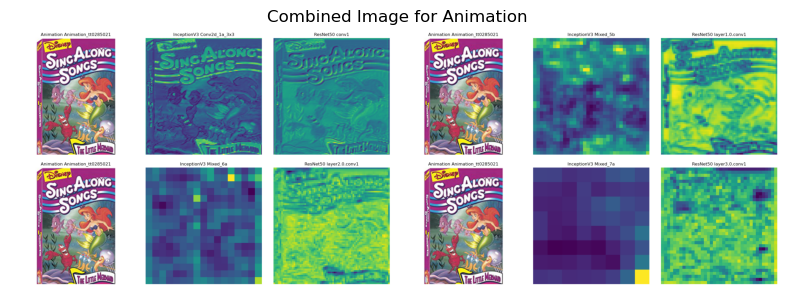

Combined image for genre Animation saved to Animation_combined.png


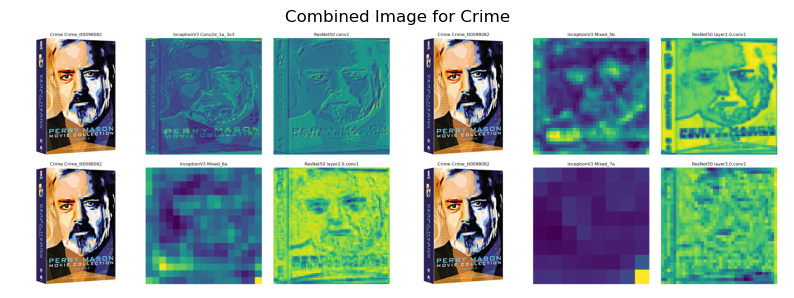

Combined image for genre Crime saved to Crime_combined.png


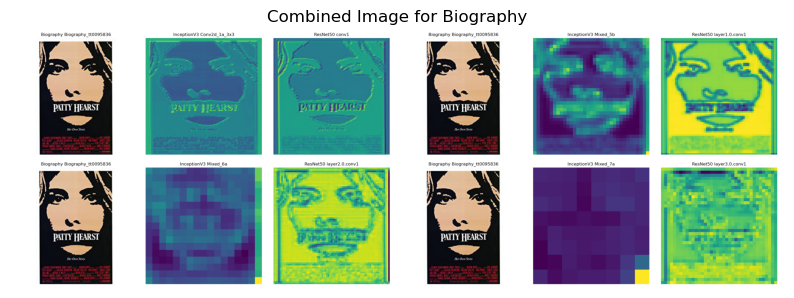

Combined image for genre Biography saved to Biography_combined.png


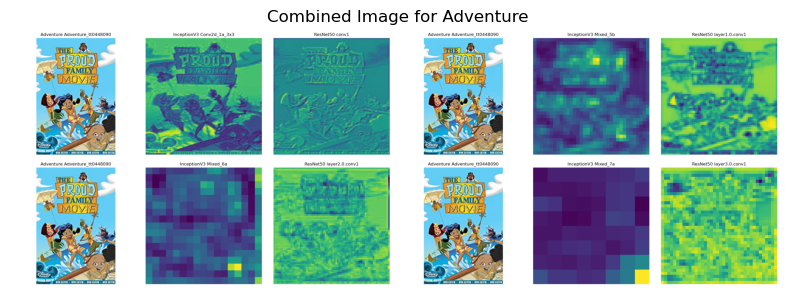

Combined image for genre Adventure saved to Adventure_combined.png


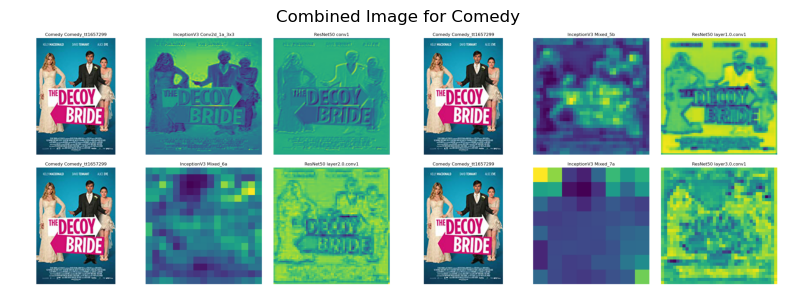

Combined image for genre Comedy saved to Comedy_combined.png


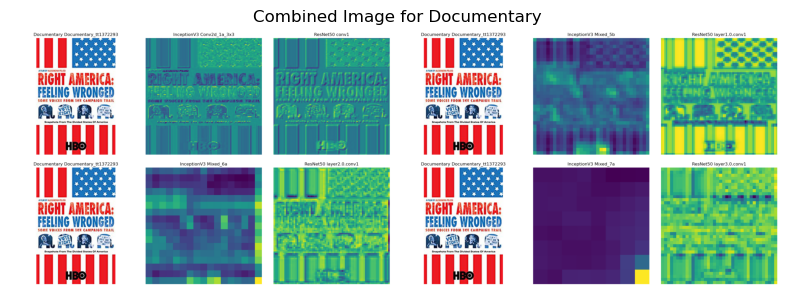

Combined image for genre Documentary saved to Documentary_combined.png


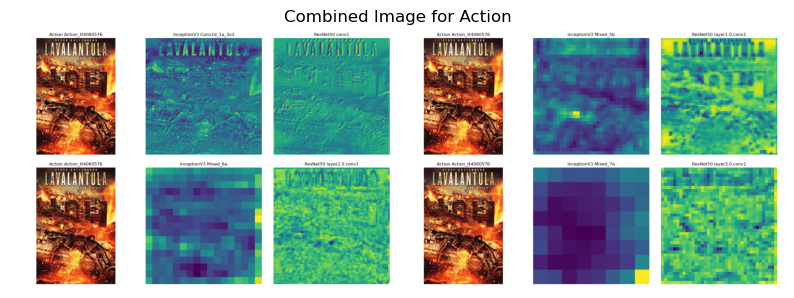

Combined image for genre Action saved to Action_combined.png


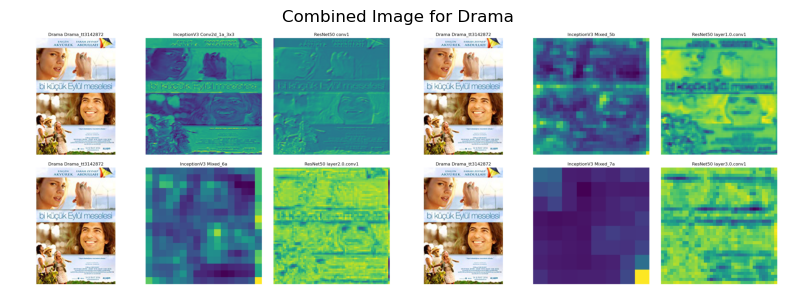

Combined image for genre Drama saved to Drama_combined.png


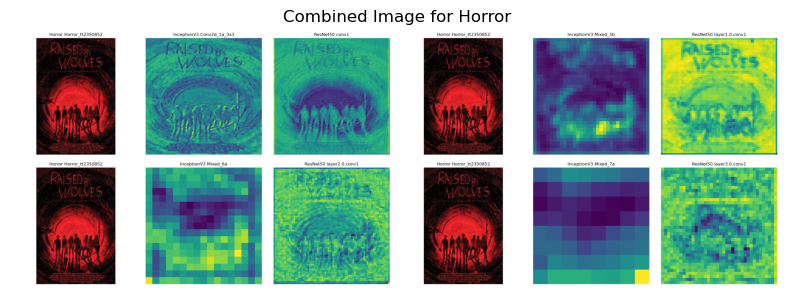

Combined image for genre Horror saved to Horror_combined.png
All comparisons complete.


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio

# Load the checkpoint to determine the number of classes
inception_checkpoint = torch.load("best_model_inception.pth")
resnet_checkpoint = torch.load("best_model_resnet50.pth")

# Extract the number of classes from the checkpoint
num_classes_inception = inception_checkpoint["fc.weight"].size(0)
num_classes_resnet = resnet_checkpoint["fc.weight"].size(0)

# Load the pre-trained InceptionV3 model and modify the final layer
inception_model = models.inception_v3(pretrained=False)
inception_model.fc = nn.Linear(inception_model.fc.in_features, num_classes_inception)
inception_model.load_state_dict(inception_checkpoint)
inception_model.eval()  # Set the model to evaluation mode

# Load the pre-trained ResNet50 model and modify the final layer
resnet_model = models.resnet50(pretrained=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes_resnet)
resnet_model.load_state_dict(resnet_checkpoint)
resnet_model.eval()  # Set the model to evaluation mode


# Function to register hooks to capture feature maps for specific layers
def register_hooks(model, layer_names):
    activation = {}
    hooks = []

    def get_activation(layer_name):
        def hook(model, input, output):
            activation[layer_name] = output

        return hook

    for name, layer in model.named_modules():
        if name in layer_names:
            hooks.append(layer.register_forward_hook(get_activation(name)))
    return activation, hooks


# Layers to compare, excluding avgpool
inception_layers = ["Conv2d_1a_3x3", "Mixed_5b", "Mixed_6a", "Mixed_7a"]
resnet_layers = ["conv1", "layer1.0.conv1", "layer2.0.conv1", "layer3.0.conv1"]

# Register hooks for both models
inception_activation, inception_hooks = register_hooks(
    inception_model, inception_layers
)
resnet_activation, resnet_hooks = register_hooks(resnet_model, resnet_layers)


# Function to preprocess the input image
def preprocess_image(img_path):
    preprocess = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    img = Image.open(img_path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img_tensor


# Function to compute and save average activation maps
def save_average_activation_maps(
    model_name, activation, img_name, layer_names, results_dir, img_size=(299, 299)
):
    os.makedirs(results_dir, exist_ok=True)

    for layer_name in layer_names:
        feature_maps = activation[layer_name]

        print(f"{model_name} - {layer_name} feature maps shape: {feature_maps.shape}")

        # Compute the average activation map for Conv2d layers
        if feature_maps.dim() == 4:
            avg_activation_map = (
                torch.mean(feature_maps, dim=1).squeeze().detach().cpu().numpy()
            )
        elif feature_maps.dim() == 2:  # For Linear layers
            avg_activation_map = feature_maps.squeeze().detach().cpu().numpy()
            avg_activation_map = avg_activation_map.reshape((1, -1))

        if (
            avg_activation_map.size == 1
        ):  # Handle case where avg_activation_map is a single value
            avg_activation_map = np.full((img_size[0], img_size[1]), avg_activation_map)

        avg_activation_map = (avg_activation_map - avg_activation_map.min()) / (
            avg_activation_map.max() - avg_activation_map.min()
        )

        avg_activation_map = np.nan_to_num(avg_activation_map)  # Replace NaNs with 0

        # Ensure the activation map is 2D
        if avg_activation_map.ndim == 3:
            avg_activation_map = avg_activation_map[0]

        # Save the average activation map
        plt.imsave(
            os.path.join(results_dir, f"{model_name}_{img_name}_{layer_name}.png"),
            avg_activation_map,
            cmap="viridis",
        )


# Function to create side-by-side comparison images with original poster on the left
def create_comparison_images_with_poster(
    poster_path,
    inception_dir,
    resnet_dir,
    output_dir,
    img_name,
    genre,
    inception_layers,
    resnet_layers,
):
    os.makedirs(output_dir, exist_ok=True)

    comparison_images = []
    for inc_layer, res_layer in zip(inception_layers, resnet_layers):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original poster
        poster_img = Image.open(poster_path)
        axes[0].imshow(poster_img)
        axes[0].set_title(f"{genre} {img_name}")
        axes[0].axis("off")

        inception_img = Image.open(
            os.path.join(inception_dir, f"inception_{img_name}_{inc_layer}.png")
        )
        resnet_img = Image.open(
            os.path.join(resnet_dir, f"resnet_{img_name}_{res_layer}.png")
        )

        axes[1].imshow(inception_img, cmap="viridis")
        axes[1].set_title(f"InceptionV3 {inc_layer}")
        axes[1].axis("off")

        axes[2].imshow(resnet_img, cmap="viridis")
        axes[2].set_title(f"ResNet50 {res_layer}")
        axes[2].axis("off")

        plt.tight_layout()
        comparison_image_path = os.path.join(
            output_dir, f"{img_name}_{inc_layer}_comparison.png"
        )
        plt.savefig(comparison_image_path)
        comparison_images.append(comparison_image_path)
        plt.close(fig)

    return comparison_images


# Function to combine images into a grid layout image per genre and display inline
def combine_images_per_genre(images, output_path):
    images = [Image.open(img) for img in images]

    # Determine the number of rows and columns based on the number of images
    num_images = len(images)
    grid_size = int(np.ceil(np.sqrt(num_images)))

    # Ensure all images are of the same size by resizing to the maximum dimensions
    max_width, max_height = max(img.size[0] for img in images), max(
        img.size[1] for img in images
    )
    images = [ImageOps.fit(img, (max_width, max_height)) for img in images]

    combined_image = Image.new("RGB", (grid_size * max_width, grid_size * max_height))

    for i, img in enumerate(images):
        x = (i % grid_size) * max_width
        y = (i // grid_size) * max_height
        combined_image.paste(img, (x, y))

    combined_image.save(output_path)

    # Display the combined image inline
    plt.figure(figsize=(10, 10))
    plt.imshow(combined_image)
    plt.axis("off")
    plt.title(f"Combined Image for {os.path.basename(output_path).split('_')[0]}")
    plt.show()


# List of image IDs and genres
images_to_compare = [
    ("Action", "tt4060576"),
    ("Adventure", "tt0448090"),
    ("Animation", "tt0285021"),
    ("Biography", "tt0095836"),
    ("Comedy", "tt1657299"),
    ("Crime", "tt0098082"),
    ("Documentary", "tt1372293"),
    ("Drama", "tt3142872"),
    ("Horror", "tt2350852"),
]

# Loop through the Posters directory and its subdirectories
root_dir = "Posters"
for genre, img_id in images_to_compare:
    found = False
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.startswith(img_id) and file.endswith(".jpg"):
                img_path = os.path.join(subdir, file)
                found = True
                break
        if found:
            break
    if found:
        img_name = f"{genre}_{img_id}"
        input_tensor = preprocess_image(img_path)

        # Forward pass to capture activations for InceptionV3
        inception_model(input_tensor)
        inception_results_dir = f"average_activations_inception_{img_name}"
        save_average_activation_maps(
            "inception",
            inception_activation,
            img_name,
            inception_layers,
            inception_results_dir,
        )

        # Forward pass to capture activations for ResNet50
        resnet_model(input_tensor)
        resnet_results_dir = f"average_activations_resnet_{img_name}"
        save_average_activation_maps(
            "resnet", resnet_activation, img_name, resnet_layers, resnet_results_dir
        )

        # Create side-by-side comparison images with original poster on the left
        output_dir = f"comparison_{img_name}"
        comparison_images = create_comparison_images_with_poster(
            img_path,
            inception_results_dir,
            resnet_results_dir,
            output_dir,
            img_name,
            genre,
            inception_layers,
            resnet_layers,
        )

        print(
            f"Comparison complete for {img_name}. Check the '{output_dir}' for results."
        )
    else:
        print(f"Image {img_id} not found in genre {genre}.")

# Combine images per genre into one grid layout image and display inline
for genre in set([g for g, _ in images_to_compare]):
    genre_images = []
    for g, img_id in images_to_compare:
        if g == genre:
            img_name = f"{g}_{img_id}"
            output_dir = f"comparison_{img_name}"
            comparison_images = [
                os.path.join(output_dir, f)
                for f in os.listdir(output_dir)
                if f.endswith(".png")
            ]
            genre_images.extend(comparison_images)
    if genre_images:
        output_path = f"{genre}_combined.png"
        combine_images_per_genre(genre_images, output_path)
        print(f"Combined image for genre {genre} saved to {output_path}")

print("All comparisons complete.")